First 10 rows:
   SITE_ID  Week  Year               DATEOFF     Ca     Cl   HNO3 HNO3 PPB  \
0  ABT147    27  2023  7/11/2023 8:00:00 AM  0.042  0.032  0.759    0.295   
1  ABT147    28  2023  7/18/2023 8:00:00 AM  0.114  0.033   0.74    0.287   
2  ABT147    29  2023  7/25/2023 8:00:00 AM  0.062  0.033  0.648    0.251   
3  ABT147    30  2023  8/01/2023 8:00:00 AM  0.064  0.033  0.598    0.232   
4  ABT147    31  2023  8/08/2023 8:00:00 AM  0.059  0.176  0.348    0.135   
5  ABT147    32  2023  8/15/2023 8:00:00 AM  0.064  0.033  0.366    0.142   
6  ABT147    33  2023  8/22/2023 8:00:00 AM  0.054  0.034  0.422    0.164   
7  ABT147    34  2023  8/29/2023 8:00:00 AM  0.041  0.034   0.25    0.097   
8  ABT147    35  2023  9/05/2023 8:00:00 AM  0.175  0.034  0.467    0.181   
9  ABT147    36  2023  9/12/2023 8:00:00 AM   0.24  0.033  0.649    0.252   

       K     Mg     Na    NH4    NO3    SO2 SO2 PPB    SO4   TNO3     DATEON  
0  0.129  0.022  0.055  0.279  0.088  0.258   0.098  0.91

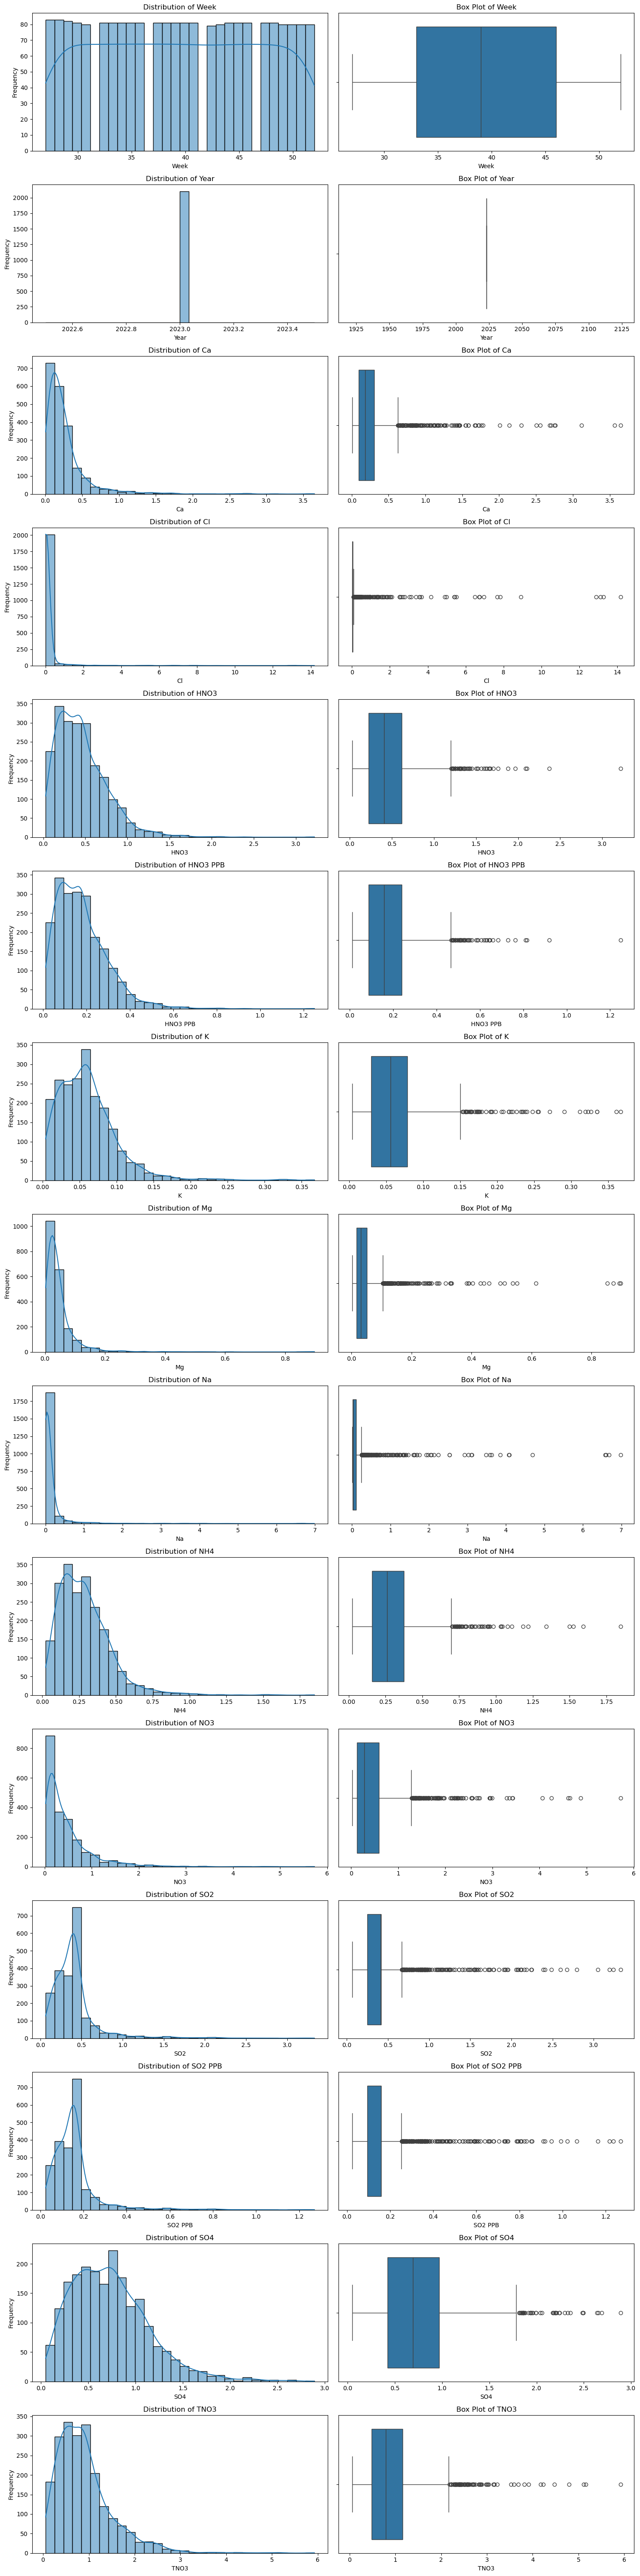

C:\Users\GANJI MANOGNA\AppData\Local\Temp\ipykernel_11036\1608265658.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Air_Quality_Category', data=df, palette='Set2')


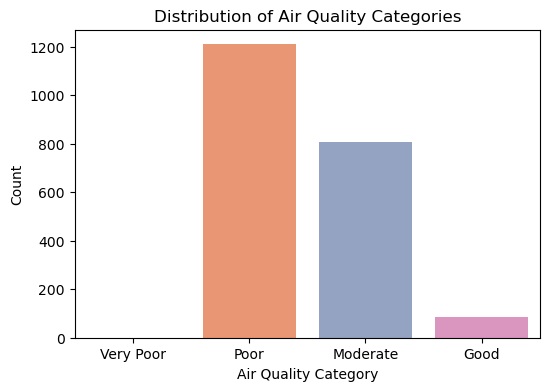

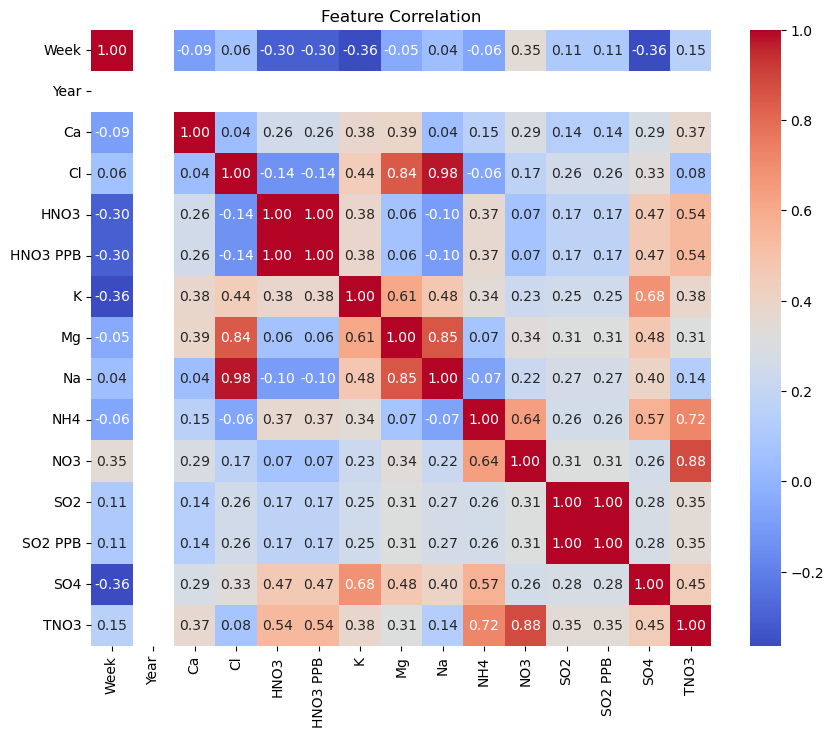

Accuracy: 0.9429928741092637
Classification Report:
               precision    recall  f1-score   support

        Good       1.00      0.47      0.64        17
    Moderate       0.92      0.93      0.93       162
        Poor       0.96      0.98      0.97       242

    accuracy                           0.94       421
   macro avg       0.96      0.80      0.85       421
weighted avg       0.94      0.94      0.94       421



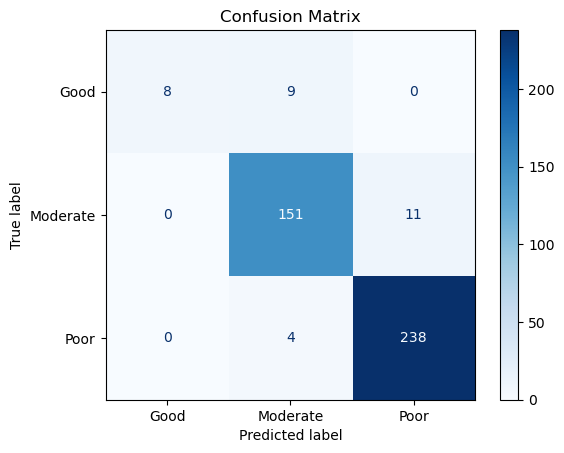

C:\Users\GANJI MANOGNA\AppData\Local\Temp\ipykernel_11036\1608265658.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(numeric_columns)[indices], palette='viridis')


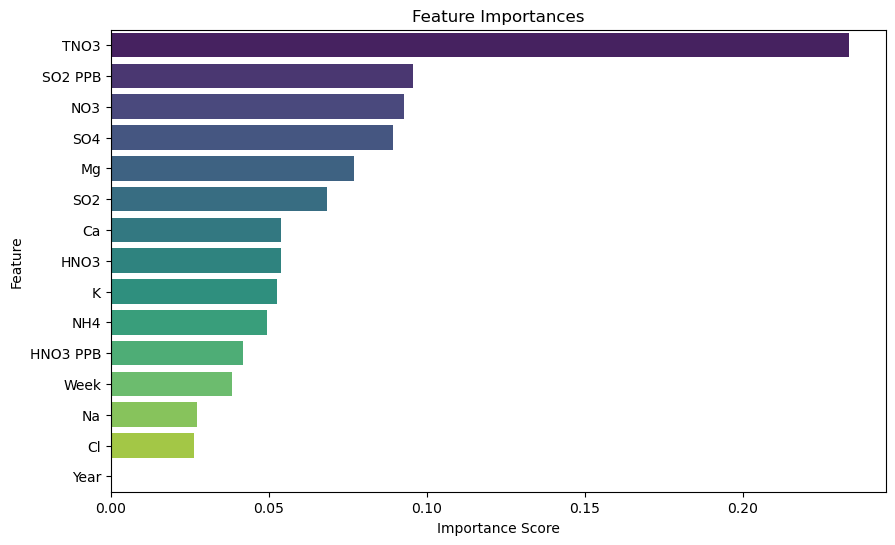

In [25]:

import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)

warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")

# 1. Load the dataset
df = pd.read_csv(r'C:\Users\GANJI MANOGNA\Downloads\air_quality_dataset.csv')
print("First 10 rows:\n", df.head(10))
print("Shape:", df.shape)
print("Info:")
df.info()

# 2. Convert date columns to datetime
for col in ['DATEOFF', 'DATEON']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# 3. Convert numeric columns to numeric dtype
numeric_columns = df.columns.drop(['SITE_ID', 'DATEOFF', 'DATEON'], errors='ignore').tolist()
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

print("\nData types after conversion:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# 4. Fill missing values with mean for numeric columns
means = df.select_dtypes(include=['int64', 'float64']).mean()
df = df.fillna(means)
print("\nMissing values after filling:\n", df.isnull().sum())

# 5. Check for duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

# 6. Visualize distributions and boxplots for all numeric variables
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, 4 * len(numeric_columns)))
for i, column in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns), 2, 2*i + 1)
    sns.histplot(df[column].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.subplot(len(numeric_columns), 2, 2*i + 2)
    sns.boxplot(x=df[column].dropna())
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

# 7. Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_columns])

# 8. Create a composite air quality index
df['Air_Quality_Index'] = np.mean(scaled_features, axis=1)

# 9. Define categories based on the index
df['Air_Quality_Category'] = pd.cut(
    df['Air_Quality_Index'],
    bins=[-np.inf, -1, 0, 1, np.inf],
    labels=['Very Poor', 'Poor', 'Moderate', 'Good']
)

# 10. Visualize the distribution of air quality categories
plt.figure(figsize=(6,4))
sns.countplot(x='Air_Quality_Category', data=df, palette='Set2')
plt.title('Distribution of Air Quality Categories')
plt.xlabel('Air Quality Category')
plt.ylabel('Count')
plt.show()

# 11. Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation')
plt.show()

# 12. Define features and target
X = df[numeric_columns]
y = df['Air_Quality_Category']

# 13. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 14. Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 15. Make predictions
y_pred = model.predict(X_test)

# 16. Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# 17. Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# 18. Feature Importance Plot
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(numeric_columns)[indices], palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()
